# Imports, parameters, pairs

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ML Enhancement Imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.style.use("default")

start_date = "2015-01-01"
end_date   = "2024-12-31"

pairs = {
    "Semis": {
        "long":  ["ASML", "TSM", "KLAC"],
        "short": ["AMD", "NVDA", "AVGO"]
    },
    "Energy": {
        "long":  ["XOM", "CVX", "COP"],
        "short": ["VLO", "MPC", "PSX"]
    },
    "Growth_vs_Tech": {
        "long":  ["RSPT", "SOXX"],
        "short": ["QQQ", "AAPL", "META"]
    },
    "Staples_vs_Discretionary": {
        "long":  ["XLP"],
        "short": ["XLY"]
    }
}

# Signal parameters
vol_lookback = 20     # days for realized volatility estimation
z_lookback   = 120    # days for z-score of vol-spread

z_entry = 2.0
z_exit  = 0.5

# Transaction cost 
tc_per_side = 0.0005
all_tickers = sorted({t for p in pairs.values() for side in ["long", "short"] for t in p[side]})

raw = yf.download(all_tickers, start=start_date, end=end_date, auto_adjust=True)

if isinstance(raw.columns, pd.MultiIndex):
    prices = raw["Close"]
else:
    prices = raw 

prices = prices.dropna(how="all")
prices = prices.ffill().bfill()

print(prices.head())
print(prices.columns)


# Equal weight basket 

In [ ]:
def basket_index(price_df, tickers):
    sub = price_df[tickers].dropna()
    # Equal weighted normalized index (start at 1)
    norm = sub / sub.iloc[0]
    idx = norm.mean(axis=1)
    return idx

# Machine Learning Enhancement Functions

These functions add a predictive ML layer to filter signal quality and improve strategy performance.

**Key Components**:
- **Feature Engineering**: 40+ features capturing spread dynamics, correlation, market regime
- **Target Variable**: Binary classification - will spread mean-revert profitably?
- **Walk-Forward Validation**: No look-ahead bias, trains only on past data
- **Feature Importance**: Identifies which signals matter most
- **Half-Life Testing**: Validates mean reversion assumption


In [ ]:
def calculate_features_for_vol_spread(df, lookback=20):
    """Calculate ML features for volatility spread prediction"""
    features = df.copy()
    
    # Spread characteristics
    features['z_score'] = features['vol_z']
    features['z_abs'] = features['vol_z'].abs()
    features['spread_magnitude'] = features['vol_spread'].abs()
    features['spread_pct_from_mean'] = (
        (features['vol_spread'] - features['vol_mu']) / features['vol_mu'].abs()
    ).fillna(0)
    
    # Spread dynamics
    features['spread_trend_5d'] = features['vol_spread'].diff(5)
    features['spread_trend_10d'] = features['vol_spread'].diff(10)
    features['spread_trend_20d'] = features['vol_spread'].diff(20)
    features['z_trend_5d'] = features['vol_z'].diff(5)
    features['z_trend_10d'] = features['vol_z'].diff(10)
    features['spread_momentum'] = features['vol_spread'].pct_change(10)
    features['spread_accel'] = features['spread_trend_10d'].diff(5)
    
    # Volatility of spread
    features['spread_volatility'] = features['vol_spread'].rolling(lookback).std()
    features['spread_cv'] = (
        features['spread_volatility'] / features['vol_spread'].abs()
    ).replace([np.inf, -np.inf], np.nan).fillna(0)
    
    # Mean reversion quality
    spread_centered = features['vol_spread'] - features['vol_mu']
    spread_sign = np.sign(spread_centered)
    features['mean_crossings_20d'] = spread_sign.diff().abs().rolling(20).sum() / 2
    crossings = (spread_sign.diff() != 0).astype(int)
    features['days_since_crossing'] = crossings.groupby(crossings.cumsum()).cumcount()
    
    # Correlation stability
    features['correlation_20d'] = features['ret_long'].rolling(20).corr(features['ret_short'])
    features['correlation_60d'] = features['ret_long'].rolling(60).corr(features['ret_short'])
    features['corr_trend'] = features['correlation_20d'] - features['correlation_60d']
    features['corr_stability'] = features['correlation_20d'].rolling(20).std()
    
    # Basket-level features
    features['vol_ratio'] = features['vol_long'] / (features['vol_short'] + 1e-6)
    features['which_more_volatile'] = (features['vol_long'] > features['vol_short']).astype(int)
    features['avg_vol'] = (features['vol_long'] + features['vol_short']) / 2
    features['vol_long_trend'] = features['vol_long'].diff(10)
    features['vol_short_trend'] = features['vol_short'].diff(10)
    
    # Market regime indicators
    features['high_vol_regime'] = (
        features['avg_vol'] > features['avg_vol'].rolling(60).quantile(0.75)
    ).astype(int)
    features['low_vol_regime'] = (
        features['avg_vol'] < features['avg_vol'].rolling(60).quantile(0.25)
    ).astype(int)
    
    # Time-based features
    features['day_of_week'] = features.index.dayofweek
    features['month'] = features.index.month
    in_signal = (features['vol_z'].abs() > 2.0).astype(int)
    features['days_in_signal'] = in_signal.groupby((in_signal != in_signal.shift()).cumsum()).cumsum()
    
    return features


def add_vix_regime(features_df, start_date, end_date):
    """Add VIX-based market regime features"""
    try:
        vix_data = yf.download("^VIX", start=start_date, end=end_date, auto_adjust=True, progress=False)
        
        if isinstance(vix_data.columns, pd.MultiIndex):
            vix = vix_data["Close"].squeeze()
        else:
            vix = vix_data["Close"]
        
        vix_aligned = vix.reindex(features_df.index, method='ffill')
        
        features_df['vix_level'] = vix_aligned
        features_df['vix_high'] = (vix_aligned > 20).astype(int)
        features_df['vix_extreme'] = (vix_aligned > 30).astype(int)
        features_df['vix_trend_10d'] = vix_aligned.diff(10)
        features_df['vix_percentile'] = vix_aligned.rolling(252).rank(pct=True)
        
    except Exception as e:
        print(f"Warning: VIX download failed, using defaults: {e}")
        features_df['vix_level'] = 15
        features_df['vix_high'] = 0
        features_df['vix_extreme'] = 0
        features_df['vix_trend_10d'] = 0
        features_df['vix_percentile'] = 0.5
    
    return features_df


def create_target_variable(features_df, forward_window=30, profit_threshold=0.001):
    """Create binary target: Will spread mean-revert profitably?"""
    target = pd.Series(0, index=features_df.index)
    
    vol_z = features_df['vol_z']
    vol_spread = features_df['vol_spread']
    
    for i in range(len(features_df) - forward_window):
        current_z = vol_z.iloc[i]
        
        if abs(current_z) < 2.0:
            continue
        
        future_z = vol_z.iloc[i+1:i+forward_window+1]
        future_spread = vol_spread.iloc[i+1:i+forward_window+1]
        
        if current_z > 2.0:
            if (future_z < 0.5).any():
                days_to_cross = (future_z < 0.5).idxmax()
                spread_change = vol_spread.iloc[i] - future_spread.loc[days_to_cross]
                if spread_change > profit_threshold:
                    target.iloc[i] = 1
        
        elif current_z < -2.0:
            if (future_z > -0.5).any():
                days_to_cross = (future_z > -0.5).idxmax()
                spread_change = future_spread.loc[days_to_cross] - vol_spread.iloc[i]
                if spread_change > profit_threshold:
                    target.iloc[i] = 1
    
    return target


def prepare_ml_dataset(features_df, target):
    """Prepare feature matrix X and target y for ML training"""
    df = features_df.copy()
    df['target'] = target
    df = df.dropna()
    
    exclude_cols = ['long_idx', 'short_idx', 'ret_long', 'ret_short', 
                    'vol_long', 'vol_short', 'vol_spread', 'vol_mu', 
                    'vol_sig', 'vol_z', 'target', 'pos', 'pair_ret',
                    'turnover', 'tc', 'ret_gross', 'ret_net']
    
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    
    X = df[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0)
    y = df['target']
    
    return X, y, df.index


def analyze_feature_importance(model, feature_names, top_n=10):
    """Analyze which features are most important"""
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    print(f"\nTOP {top_n} FEATURES:")
    for i in range(min(top_n, len(feature_names))):
        idx = indices[i]
        print(f"  {i+1:2d}. {feature_names[idx]:25s} {importances[idx]:.4f}")
    
    return importances, indices


def halflife_analysis(spread_series, name):
    """Calculate half-life and test stationarity"""
    spread_clean = spread_series.dropna()
    
    spread_lag = spread_clean.shift(1).dropna()
    spread_diff = spread_clean.diff().dropna()
    common_idx = spread_lag.index.intersection(spread_diff.index)
    
    if len(common_idx) < 30:
        return np.nan, np.nan
    
    slope, _, _, _, _ = stats.linregress(spread_lag.loc[common_idx], spread_diff.loc[common_idx])
    
    if slope < 0 and slope > -1:
        half_life = -np.log(2) / np.log(1 + slope)
    else:
        half_life = np.inf
    
    adf_result = adfuller(spread_clean, maxlag=20)
    adf_pvalue = adf_result[1]
    
    print(f"\n{name}:")
    print(f"  Half-life: {half_life:.1f} days")
    print(f"  ADF p-value: {adf_pvalue:.4f} {'✓ Stationary' if adf_pvalue < 0.05 else '⚠ Non-stationary'}")
    
    return half_life, adf_pvalue


# Baseline Volatility Dispersion Strategy (No ML)

This is the original strategy for comparison purposes.


In [ ]:
def backtest_vol_dispersion_pair(name, pair_def, price_df,
                                 vol_lookback=20,
                                 z_lookback=120,
                                 z_entry=2.0,
                                 z_exit=0.5,
                                 tc_per_side=0.0005):
    long_idx  = basket_index(price_df, pair_def["long"])
    short_idx = basket_index(price_df, pair_def["short"])
    
    # Daily returns of basket indices
    ret_long  = long_idx.pct_change().fillna(0)
    ret_short = short_idx.pct_change().fillna(0)
    
    # Realized volatility (rolling std of returns)
    vol_long  = ret_long.rolling(vol_lookback).std() * np.sqrt(252)
    vol_short = ret_short.rolling(vol_lookback).std() * np.sqrt(252)
    
    vol_spread = vol_long - vol_short
    
    # Z-score of vol-spread
    mu  = vol_spread.rolling(z_lookback).mean()
    sig = vol_spread.rolling(z_lookback).std()
    z   = (vol_spread - mu) / sig
    
    df = pd.DataFrame({
        "long_idx": long_idx,
        "short_idx": short_idx,
        "ret_long": ret_long,
        "ret_short": ret_short,
        "vol_long": vol_long,
        "vol_short": vol_short,
        "vol_spread": vol_spread,
        "vol_mu": mu,
        "vol_sig": sig,
        "vol_z": z,
    }).dropna()
    
    # Position rules based on vol_z
    pos = np.zeros(len(df))
    
    for i in range(1, len(df)):
        prev_pos = pos[i-1]
        z_now = df["vol_z"].iloc[i]
        
        # Entry signals
        if prev_pos == 0:
            if z_now > z_entry:
                # long low-vol (short long basket, long short basket)
                pos[i] = -1
            elif z_now < -z_entry:
                # long high-vol (long long basket, short short basket)
                pos[i] = 1
            else:
                pos[i] = 0
        else:
            # Exit condition when vol dispersion normalizes
            if abs(z_now) < z_exit:
                pos[i] = 0
            else:
                pos[i] = prev_pos
    
    df["pos"] = pos
    
    # Pair return: long_long  long_short, scaled by previous day's position (to avoid look-ahead)
    df["pair_ret"] = df["pos"].shift(1) * (df["ret_long"] - df["ret_short"])
    df["pair_ret"] = df["pair_ret"].fillna(0)
    
    # Turnover & transaction costs
    pos_change = df["pos"].diff().abs().fillna(0)
    turnover = pos_change  # position is ±1 or 0, so change is number of "round turns"
    
    df["turnover"] = turnover
    df["tc"] = turnover * (2 * tc_per_side)  # both sides when we enter/exit
    df["ret_gross"] = df["pair_ret"]
    df["ret_net"] = df["ret_gross"] - df["tc"]
    
    return df


# ML-Enhanced Volatility Dispersion Strategy

This version adds machine learning to predict signal quality.

**Enhancements**:
1. Random Forest classifier filters low-quality signals
2. Walk-forward validation (trains only on past data)
3. Adaptive entry thresholds based on VIX regime
4. Quarterly retraining to adapt to market changes

**Parameters**:
- `use_ml`: Enable/disable ML filter
- `min_ml_prob`: Minimum confidence threshold (default: 60%)
- `retrain_freq`: How often to retrain model (default: 63 days / quarterly)


In [ ]:
def backtest_vol_dispersion_ml(name, pair_def, price_df,
                               vol_lookback=20,
                               z_lookback=120,
                               base_z_entry=2.0,
                               z_exit=0.5,
                               tc_per_side=0.0005,
                               use_ml=True,
                               min_ml_prob=0.6,
                               retrain_freq=63):
    """ML-Enhanced Volatility Dispersion Backtest"""
    
    # Step 1: Calculate volatility spreads
    long_idx = basket_index(price_df, pair_def["long"])
    short_idx = basket_index(price_df, pair_def["short"])
    
    ret_long = long_idx.pct_change().fillna(0)
    ret_short = short_idx.pct_change().fillna(0)
    
    vol_long = ret_long.rolling(vol_lookback).std() * np.sqrt(252)
    vol_short = ret_short.rolling(vol_lookback).std() * np.sqrt(252)
    
    vol_spread = vol_long - vol_short
    mu = vol_spread.rolling(z_lookback).mean()
    sig = vol_spread.rolling(z_lookback).std()
    z = (vol_spread - mu) / sig
    
    df = pd.DataFrame({
        "long_idx": long_idx,
        "short_idx": short_idx,
        "ret_long": ret_long,
        "ret_short": ret_short,
        "vol_long": vol_long,
        "vol_short": vol_short,
        "vol_spread": vol_spread,
        "vol_mu": mu,
        "vol_sig": sig,
        "vol_z": z,
    }).dropna()
    
    # Step 2: Feature engineering
    print(f"  {name}: Engineering features...")
    df = calculate_features_for_vol_spread(df, lookback=20)
    df = add_vix_regime(df, price_df.index[0], price_df.index[-1])
    
    # Step 3: Create target variable
    print(f"  {name}: Creating target...")
    target = create_target_variable(df, forward_window=30)
    
    # Step 4: Prepare ML dataset
    X, y, valid_idx = prepare_ml_dataset(df, target)
    
    print(f"  {name}: Dataset shape: X={X.shape}, y={y.shape}")
    print(f"  {name}: Target: {y.value_counts().to_dict()}")
    
    # Step 5: Train ML model (walk-forward)
    ml_predictions = pd.Series(0.5, index=df.index)
    ml_signal_quality = pd.Series(0, index=df.index)
    
    if use_ml and len(y) > 252:
        print(f"  {name}: Training ML model...")
        
        min_train_size = 252
        
        for i in range(min_train_size, len(X), retrain_freq):
            X_train = X.iloc[:i]
            y_train = y.iloc[:i]
            X_test = X.iloc[i:min(i+retrain_freq, len(X))]
            
            if len(X_train) < min_train_size or len(X_test) == 0:
                continue
            
            model = RandomForestClassifier(
                n_estimators=100,
                max_depth=10,
                min_samples_split=20,
                min_samples_leaf=10,
                random_state=42,
                n_jobs=-1
            )
            
            model.fit(X_train, y_train)
            probs = model.predict_proba(X_test)[:, 1]
            
            test_idx = X.index[i:min(i+retrain_freq, len(X))]
            ml_predictions.loc[test_idx] = probs
            ml_signal_quality.loc[test_idx] = 1
            
            if i == min_train_size:
                print(f"  {name}: Feature importance:")
                analyze_feature_importance(model, X.columns, top_n=10)
        
        # Calculate AUC
        valid_ml_idx = ml_signal_quality[ml_signal_quality == 1].index
        if len(valid_ml_idx) > 0:
            y_ml = y.loc[valid_ml_idx]
            pred_ml = ml_predictions.loc[valid_ml_idx]
            
            try:
                from sklearn.metrics import roc_auc_score
                auc = roc_auc_score(y_ml, pred_ml)
                print(f"  {name}: ML AUC: {auc:.3f}")
            except:
                pass
    
    df['ml_prob'] = ml_predictions
    df['ml_quality'] = ml_signal_quality
    
    # Step 6: Generate positions with ML filter
    pos = np.zeros(len(df))
    z_entry_adaptive = np.full(len(df), base_z_entry)
    
    for i in range(1, len(df)):
        prev_pos = pos[i-1]
        z_now = df["vol_z"].iloc[i]
        ml_prob = df['ml_prob'].iloc[i]
        has_ml = df['ml_quality'].iloc[i] == 1
        
        # Adaptive z-score based on VIX
        if df['vix_extreme'].iloc[i] == 1:
            z_entry = base_z_entry * 1.25
        elif df['vix_high'].iloc[i] == 1:
            z_entry = base_z_entry * 1.1
        else:
            z_entry = base_z_entry
        
        z_entry_adaptive[i] = z_entry
        
        # Entry logic
        if prev_pos == 0:
            signal_strong = abs(z_now) > z_entry
            
            if use_ml and has_ml:
                ml_approved = ml_prob > min_ml_prob
            else:
                ml_approved = True
            
            if signal_strong and ml_approved:
                if z_now > z_entry:
                    pos[i] = -1
                elif z_now < -z_entry:
                    pos[i] = 1
        else:
            if abs(z_now) < z_exit:
                pos[i] = 0
            else:
                pos[i] = prev_pos
    
    df["pos"] = pos
    df["z_entry_adaptive"] = z_entry_adaptive
    
    # Step 7: Calculate returns
    df["pair_ret"] = df["pos"].shift(1) * (df["ret_long"] - df["ret_short"])
    df["pair_ret"] = df["pair_ret"].fillna(0)
    
    pos_change = df["pos"].diff().abs().fillna(0)
    df["turnover"] = pos_change
    df["tc"] = pos_change * (2 * tc_per_side)
    df["ret_gross"] = df["pair_ret"]
    df["ret_net"] = df["ret_gross"] - df["tc"]
    
    # Step 8: Calculate no-ML baseline for comparison
    pos_no_ml = np.zeros(len(df))
    for i in range(1, len(df)):
        if pos_no_ml[i-1] == 0:
            if df["vol_z"].iloc[i] > base_z_entry:
                pos_no_ml[i] = -1
            elif df["vol_z"].iloc[i] < -base_z_entry:
                pos_no_ml[i] = 1
        else:
            if abs(df["vol_z"].iloc[i]) < z_exit:
                pos_no_ml[i] = 0
            else:
                pos_no_ml[i] = pos_no_ml[i-1]
    
    df["pos_no_ml"] = pos_no_ml
    df["ret_no_ml"] = df["pos_no_ml"].shift(1) * (df["ret_long"] - df["ret_short"])
    df["ret_no_ml"] = df["ret_no_ml"].fillna(0)
    turnover_no_ml = df["pos_no_ml"].diff().abs().fillna(0)
    df["ret_no_ml_net"] = df["ret_no_ml"] - turnover_no_ml * (2 * tc_per_side)
    
    # Compare performance
    ml_periods = df[df['ml_quality'] == 1].copy()
    
    if len(ml_periods) > 0:
        ml_ret = ml_periods["ret_net"]
        noml_ret = ml_periods["ret_no_ml_net"]
        
        sharpe_ml = (ml_ret.mean() * 252) / (ml_ret.std() * np.sqrt(252)) if ml_ret.std() > 0 else 0
        sharpe_no_ml = (noml_ret.mean() * 252) / (noml_ret.std() * np.sqrt(252)) if noml_ret.std() > 0 else 0
        
        print(f"  {name} Performance:")
        print(f"    Sharpe with ML:    {sharpe_ml:.3f}")
        print(f"    Sharpe without ML: {sharpe_no_ml:.3f}")
        print(f"    Improvement:       {sharpe_ml - sharpe_no_ml:+.3f}")
    
    return df


# Run Backtests: Baseline vs ML-Enhanced

We run both versions to compare performance.


In [ ]:
# ===========================================================================
# RUN BASELINE BACKTEST (NO ML)
# ===========================================================================

print("="*70)
print("BASELINE BACKTEST (No ML)")
print("="*70)

results_baseline = {}
baseline_rows = []

for name, pair_def in pairs.items():
    print(f"\nBaseline: {name}...")
    df_pair = backtest_vol_dispersion_pair(
        name, pair_def, prices,
        vol_lookback=vol_lookback,
        z_lookback=z_lookback,
        z_entry=z_entry,
        z_exit=z_exit,
        tc_per_side=tc_per_side
    )
    results_baseline[name] = df_pair
    
    r = df_pair["ret_net"].dropna()
    mu = r.mean() * 252
    sig = r.std() * np.sqrt(252)
    sharpe = mu / sig if sig > 0 else np.nan
    
    baseline_rows.append({
        "pair": name,
        "ann_return": mu,
        "ann_vol": sig,
        "sharpe_baseline": sharpe,
    })

baseline_summary = pd.DataFrame(baseline_rows)
print("\n" + "="*70)
print("BASELINE PERFORMANCE")
print("="*70)
print(baseline_summary.to_string(index=False))


# ===========================================================================
# RUN ML-ENHANCED BACKTEST
# ===========================================================================

print("\n\n" + "="*70)
print("ML-ENHANCED BACKTEST")
print("="*70)

results_ml = {}
ml_rows = []

for name, pair_def in pairs.items():
    print(f"\n{'='*70}")
    print(f"ML: {name}")
    print('='*70)
    
    df_pair = backtest_vol_dispersion_ml(
        name, pair_def, prices,
        vol_lookback=vol_lookback,
        z_lookback=z_lookback,
        base_z_entry=z_entry,
        z_exit=z_exit,
        tc_per_side=tc_per_side,
        use_ml=True,
        min_ml_prob=0.60,
        retrain_freq=63
    )
    
    results_ml[name] = df_pair
    
    r = df_pair["ret_net"].dropna()
    mu = r.mean() * 252
    sig = r.std() * np.sqrt(252)
    sharpe_ml = mu / sig if sig > 0 else np.nan
    
    ml_data = df_pair[df_pair['ml_quality'] == 1]
    ml_trades = (df_pair['pos'].diff().abs() > 0).sum()
    ml_coverage = len(ml_data) / len(df_pair) if len(df_pair) > 0 else 0
    
    ml_rows.append({
        "pair": name,
        "ann_return": mu,
        "ann_vol": sig,
        "sharpe_ml": sharpe_ml,
        "num_trades": ml_trades,
        "ml_coverage": ml_coverage,
    })

ml_summary = pd.DataFrame(ml_rows)
print("\n" + "="*70)
print("ML-ENHANCED PERFORMANCE")
print("="*70)
print(ml_summary.to_string(index=False))


# ===========================================================================
# COMPARISON TABLE
# ===========================================================================

print("\n" + "="*70)
print("COMPARISON: ML vs BASELINE")
print("="*70)

comparison = baseline_summary[['pair', 'sharpe_baseline']].merge(
    ml_summary[['pair', 'sharpe_ml', 'num_trades', 'ml_coverage']], 
    on='pair'
)
comparison['improvement'] = comparison['sharpe_ml'] - comparison['sharpe_baseline']
comparison['improvement_pct'] = (comparison['improvement'] / comparison['sharpe_baseline'] * 100).round(1)

print(comparison.to_string(index=False))
print(f"\nAverage Sharpe Improvement: {comparison['improvement'].mean():+.3f}")
print(f"Average ML Coverage: {comparison['ml_coverage'].mean()*100:.1f}%")


# ===========================================================================
# HALF-LIFE ANALYSIS
# ===========================================================================

print("\n" + "="*70)
print("MEAN REVERSION ANALYSIS (HALF-LIFE)")
print("="*70)

for name, df_pair in results_ml.items():
    hl, pval = halflife_analysis(df_pair['vol_spread'], name)


# Yearly excess returns vs SPY

[*********************100%***********************]  1 of 1 completed


Semis – Yearly Excess Return vs SPY:
year
2015    0.024098
2016   -0.430002
2017   -0.321973
2018    0.398945
2019   -0.255339
2020   -0.374849
2021   -0.277011
2022    0.281257
2023   -0.249665
2024   -0.167523
Name: excess_ret, dtype: float64


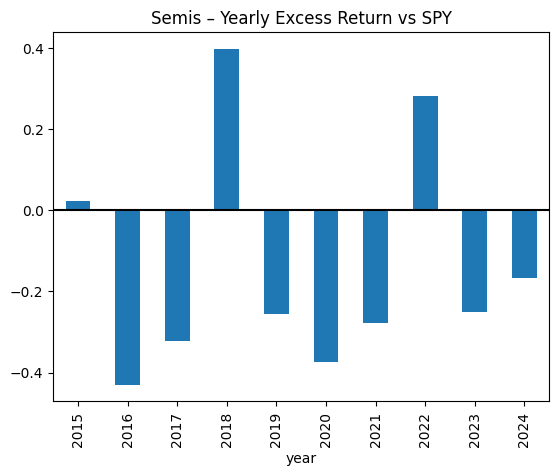


Energy – Yearly Excess Return vs SPY:
year
2015   -0.007996
2016   -0.178079
2017   -0.218995
2018    0.181721
2019   -0.108708
2020   -0.507759
2021   -0.260666
2022    0.101051
2023   -0.083540
2024   -0.136335
Name: excess_ret, dtype: float64


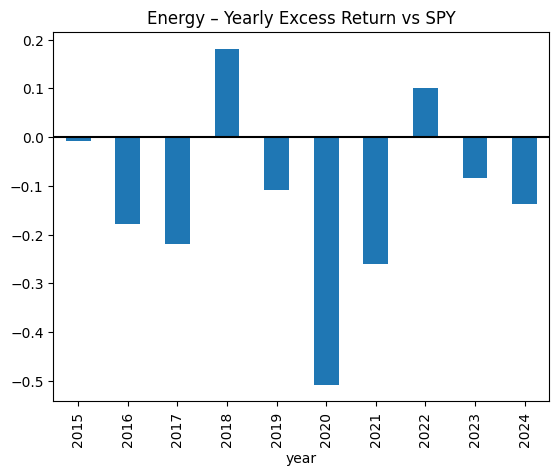


Growth_vs_Tech – Yearly Excess Return vs SPY:
year
2015    0.048294
2016   -0.118482
2017   -0.166359
2018   -0.020919
2019   -0.276522
2020   -0.321872
2021   -0.260453
2022    0.286301
2023   -0.191919
2024   -0.109735
Name: excess_ret, dtype: float64


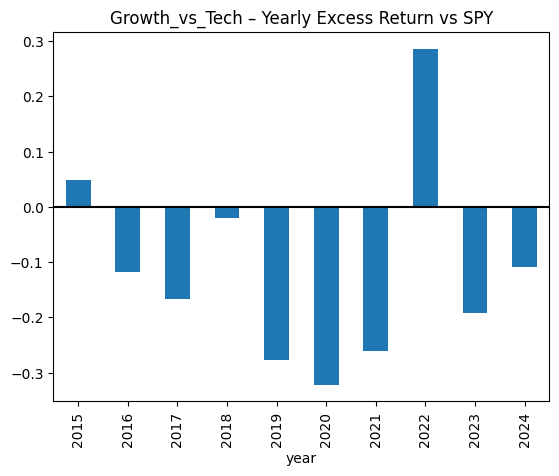


Staples_vs_Discretionary – Yearly Excess Return vs SPY:
year
2015   -0.010354
2016   -0.156831
2017   -0.161301
2018   -0.019451
2019   -0.320516
2020   -0.411144
2021   -0.187396
2022   -0.034333
2023   -0.098621
2024   -0.240969
Name: excess_ret, dtype: float64


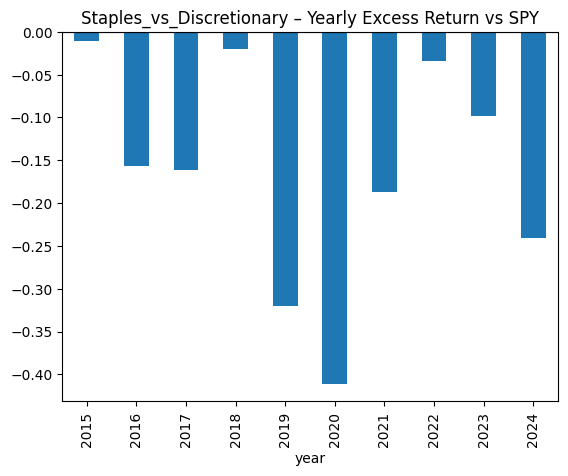

In [ ]:

spy_raw = yf.download("SPY", start=start_date, end=end_date, auto_adjust=True)
if isinstance(spy_raw.columns, pd.MultiIndex):
    spy_px = spy_raw["Close"]
else:
    spy_px = spy_raw["Close"] if "Close" in spy_raw.columns else spy_raw.iloc[:, 0]

spy_ret = spy_px.pct_change().fillna(0)

def yearly_excess_returns(df_pair, benchmark):
    df = df_pair.copy()
    bench = benchmark.reindex(df.index).fillna(0)
    df["bench"] = bench
    df["excess_ret"] = df["ret_net"] - df["bench"]
    df["year"] = df.index.year
    yearly = df.groupby("year")["excess_ret"].apply(lambda x: (1 + x).prod() - 1)
    return yearly

for name, df_pair in results.items():
    yr_excess = yearly_excess_returns(df_pair, benchmark=spy_ret)
    print(f"\n{name} – Yearly Excess Return vs SPY:")
    print(yr_excess)
    
    yr_excess.plot(kind="bar", title=f"{name} – Yearly Excess Return vs SPY")
    plt.axhline(0, color="black")
    plt.show()


# Correlation matrices

In [11]:
def pair_correlation(price_df, pair_def):
    tickers = pair_def["long"] + pair_def["short"]
    sub = price_df[tickers].dropna()
    ret = sub.pct_change().dropna()
    return ret.corr()

for name, definition in pairs.items():
    corr = pair_correlation(prices, definition)
    print(f"\n{name} correlation matrix:")
    print(corr)



Semis correlation matrix:
Ticker      ASML       TSM      KLAC       AMD      NVDA      AVGO
Ticker                                                            
ASML    1.000000  0.665788  0.763264  0.490769  0.629575  0.634307
TSM     0.665788  1.000000  0.638971  0.457242  0.593582  0.587653
KLAC    0.763264  0.638971  1.000000  0.489561  0.625397  0.623097
AMD     0.490769  0.457242  0.489561  1.000000  0.578717  0.433706
NVDA    0.629575  0.593582  0.625397  0.578717  1.000000  0.581694
AVGO    0.634307  0.587653  0.623097  0.433706  0.581694  1.000000

Energy correlation matrix:
Ticker       XOM       CVX       COP       VLO       MPC       PSX
Ticker                                                            
XOM     1.000000  0.833098  0.791224  0.664762  0.647750  0.725183
CVX     0.833098  1.000000  0.812687  0.645463  0.641961  0.714769
COP     0.791224  0.812687  1.000000  0.608747  0.629280  0.699128
VLO     0.664762  0.645463  0.608747  1.000000  0.843074  0.848669
MPC    

# extended performance : Drawdown & Tail risk

In [12]:
def max_drawdown(returns: pd.Series):
    curve = (1 + returns).cumprod()
    peak = curve.cummax()
    dd = curve / peak - 1
    return dd.min()

def hist_var_cvar(returns: pd.Series, alpha=0.99):
    r = returns.dropna().sort_values()
    var = r.quantile(1 - alpha)
    cvar = r[r <= var].mean() if (r <= var).any() else var
    return var, cvar

summary_rows = []

for name, df_pair in results.items():
    r = df_pair["ret_net"].dropna()
    mu = r.mean()
    sig = r.std()
    
    ann_mu = mu * 252
    ann_vol = sig * np.sqrt(252)
    sharpe = ann_mu / ann_vol if ann_vol > 0 else np.nan
    avg_turnover = df_pair["turnover"].mean()
    mdd = max_drawdown(r)
    var99, cvar99 = hist_var_cvar(r, alpha=0.99)
    
    summary_rows.append({
        "pair": name,
        "ann_net_return": ann_mu,
        "ann_vol": ann_vol,
        "sharpe_net": sharpe,
        "avg_daily_turnover": avg_turnover,
        "max_drawdown": mdd,
        "VaR_99_daily": var99,
        "CVaR_99_daily": cvar99,
    })

summary_ext = pd.DataFrame(summary_rows)
print(summary_ext)


                       pair  ann_net_return   ann_vol  sharpe_net  \
0                     Semis       -0.029638  0.159274   -0.186083   
1                    Energy        0.000980  0.126528    0.007744   
2            Growth_vs_Tech        0.018686  0.103173    0.181113   
3  Staples_vs_Discretionary       -0.036927  0.109352   -0.337693   

   avg_daily_turnover  max_drawdown  VaR_99_daily  CVaR_99_daily  
0            0.018511     -0.502984     -0.033380      -0.047426  
1            0.028607     -0.503079     -0.026529      -0.045369  
2            0.021876     -0.259835     -0.020267      -0.029050  
3            0.019352     -0.425825     -0.023423      -0.031746  


# Equity Curves

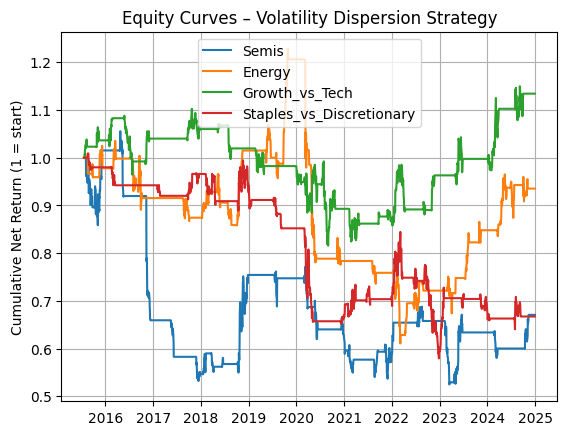

In [13]:
def equity_curve(df_pair):
    return (1 + df_pair["ret_net"].fillna(0)).cumprod()

plt.figure()
for name, df_pair in results.items():
    curve = equity_curve(df_pair)
    plt.plot(curve.index, curve, label=name)
plt.title("Equity Curves – Volatility Dispersion Strategy")
plt.ylabel("Cumulative Net Return (1 = start)")
plt.legend()
plt.grid(True)
plt.show()


# Vol-Spread & Z-Score visuals for each basket

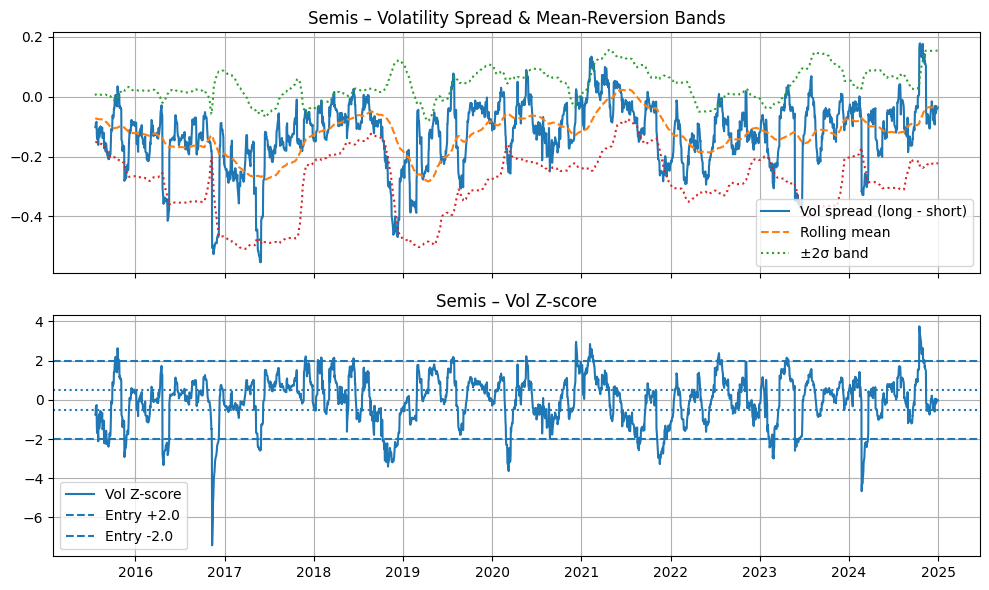

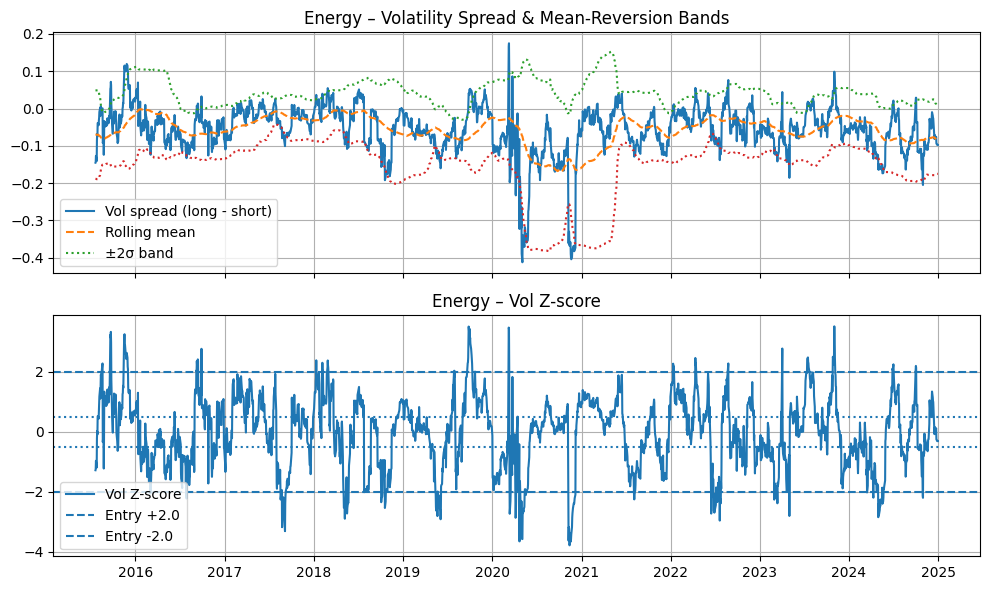

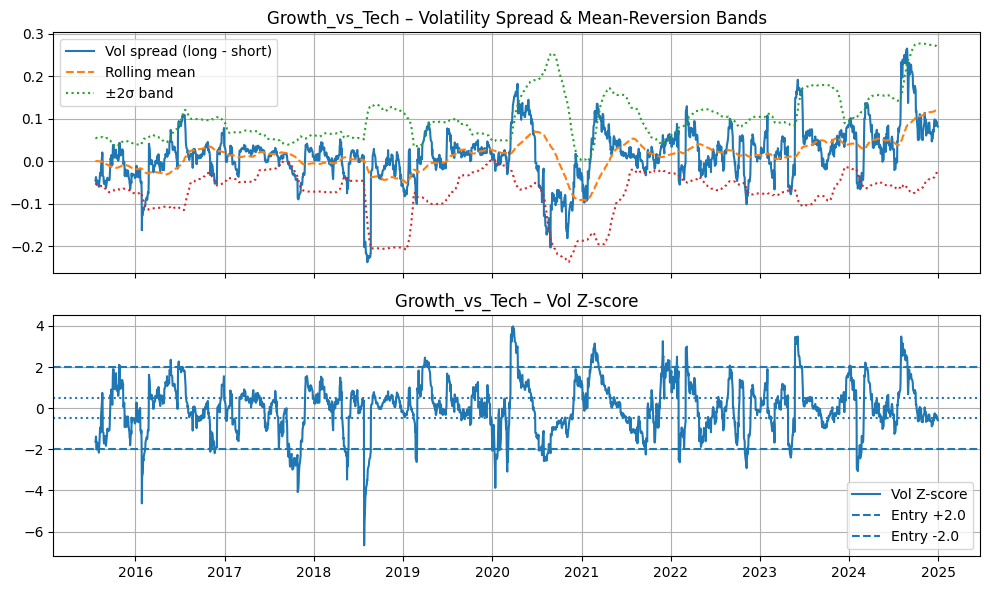

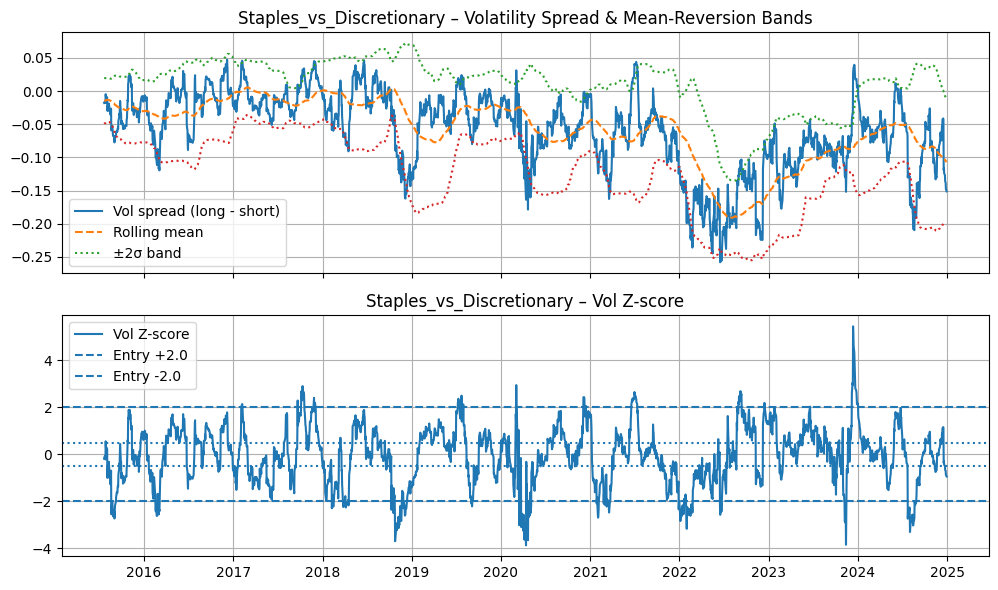

In [ ]:
def plot_vol_spread_and_z(name, df_pair):
    fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

    axes[0].plot(df_pair.index, df_pair["vol_spread"], label="Vol spread (long - short)")
    axes[0].plot(df_pair.index, df_pair["vol_mu"], linestyle="--", label="Rolling mean")
    axes[0].plot(df_pair.index, df_pair["vol_mu"] + 2*df_pair["vol_sig"], linestyle=":", label="±2σ band")
    axes[0].plot(df_pair.index, df_pair["vol_mu"] - 2*df_pair["vol_sig"], linestyle=":")
    axes[0].set_title(f"{name} – Volatility Spread & Mean-Reversion Bands")
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(df_pair.index, df_pair["vol_z"], label="Vol Z-score")
    axes[1].axhline(z_entry, linestyle="--", label=f"Entry +{z_entry}")
    axes[1].axhline(-z_entry, linestyle="--", label=f"Entry -{z_entry}")
    axes[1].axhline(z_exit, linestyle=":")
    axes[1].axhline(-z_exit, linestyle=":")
    axes[1].set_title(f"{name} – Vol Z-score")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

for name, df_pair in results.items():
    plot_vol_spread_and_z(name, df_pair)



# ML-Specific Visualizations

Visualize ML predictions, signal quality, and performance comparison.


In [ ]:
def plot_ml_predictions(df_pair, pair_name):
    """Visualize ML predictions vs actual outcomes"""
    fig, axes = plt.subplots(3, 1, figsize=(14, 10))
    
    # Plot 1: Volatility Spread and Bands
    ax1 = axes[0]
    ax1.plot(df_pair.index, df_pair['vol_spread'], label='Vol Spread', alpha=0.7)
    ax1.plot(df_pair.index, df_pair['vol_mu'], label='Mean', linestyle='--', alpha=0.7)
    ax1.fill_between(df_pair.index, 
                     df_pair['vol_mu'] - 2*df_pair['vol_sig'],
                     df_pair['vol_mu'] + 2*df_pair['vol_sig'],
                     alpha=0.2, label='±2σ Band')
    ax1.set_title(f'{pair_name}: Volatility Spread')
    ax1.set_ylabel('Volatility Spread')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: ML Probability
    ax2 = axes[1]
    ax2.plot(df_pair.index, df_pair['ml_prob'], label='ML Probability', color='purple', alpha=0.7)
    ax2.axhline(y=0.6, color='red', linestyle='--', label='Threshold (60%)', alpha=0.5)
    ax2.scatter(df_pair[df_pair['pos'] != 0].index, 
               df_pair[df_pair['pos'] != 0]['ml_prob'],
               color='green', s=20, alpha=0.6, label='Actual Trades')
    ax2.set_title(f'{pair_name}: ML Signal Quality')
    ax2.set_ylabel('Probability')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Cumulative Returns
    ax3 = axes[2]
    cum_ml = (1 + df_pair['ret_net']).cumprod()
    cum_noml = (1 + df_pair['ret_no_ml_net']).cumprod()
    ax3.plot(df_pair.index, cum_noml, label='Without ML', alpha=0.7, linestyle='--')
    ax3.plot(df_pair.index, cum_ml, label='With ML', alpha=0.9)
    ax3.set_title(f'{pair_name}: Cumulative Returns')
    ax3.set_ylabel('Cumulative Return')
    ax3.set_xlabel('Date')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Generate plots for all pairs
for name, df_pair in results_ml.items():
    fig = plot_ml_predictions(df_pair, name)
    plt.show()
